# Modelling

In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, RatingSVD, LogisticSVD
from RecData import RecData

## Data Preprocessing

In [2]:
# recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')
recs = pd.read_csv('data/full_pruned.csv')

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482464, 3)


,app_id,is_recommended,user_id
420790,12210,True,240
675882,22380,True,240
246231,239140,True,240
539676,251570,True,240
521289,270880,True,240


In [3]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [4]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

print("Creating splits...")
train_data, val = rec_data.leave_k_out_split(k=1, create_val=False)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 1 / 63175
Done user 10001 / 63175
Done user 20001 / 63175
Done user 30001 / 63175
Done user 40001 / 63175
Done user 50001 / 63175
Done user 60001 / 63175
Done creating splits.


In [5]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [6]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [7]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

In [ ]:
# for pruned, epoch: 80, lr:0.01, reg:0.02, k=100
# for 2plus, epoch: 80, lr:0.01, reg:0.02, k=100

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = RatingSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
    learning_rate=0.001, C=0.02)
svd_predictor.fit(train_data.get_matrix(), 60, validation_set=val, early_stop=False)
# svd_predictor = LogisticSVD(
#     train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
#     learning_rate=0.01, C=0.04)
# svd_predictor.fit(train_data.get_matrix(), 40, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training loss')
plt.plot(range(len(val_errors)), val_errors, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Validation rmse", rmse)

We can now continue to train if we believe the model is still underfitting.

In [36]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training loss: 0.3339409379564407/Validation loss: 0.343504477147107/Time: 6.69 seconds
Epoch 1/Training loss: 0.33373533035312236/Validation loss: 0.34331828314924634/Time: 6.73 seconds
Epoch 2/Training loss: 0.33353720127707137/Validation loss: 0.3431832637213648/Time: 6.62 seconds
Epoch 3/Training loss: 0.33333869292253293/Validation loss: 0.34306799699111024/Time: 6.68 seconds
Epoch 4/Training loss: 0.333156469040551/Validation loss: 0.34295658430180254/Time: 6.66 seconds


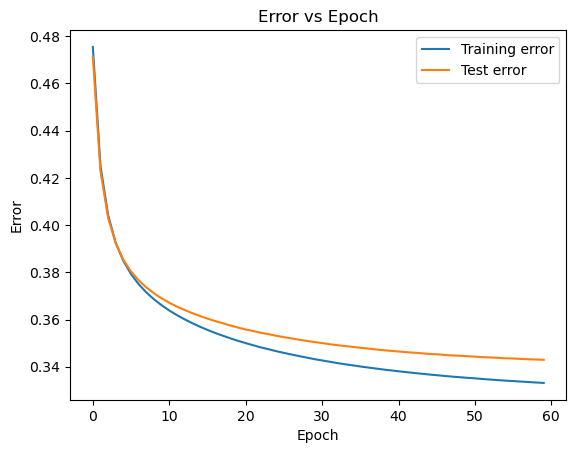

Test rmse 0.34295658430180254


In [37]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [57]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 1 / 2215
Upto row 201 / 2215
Upto row 401 / 2215
Upto row 601 / 2215
Upto row 801 / 2215
Upto row 1001 / 2215
Upto row 1201 / 2215
Upto row 1401 / 2215
Upto row 1601 / 2215
Upto row 1801 / 2215
Upto row 2001 / 2215
Upto row 2201 / 2215
Done computing similarities in 454.7012801170349 seconds


## Preparing for Production

In [183]:
svd_predictor.prep_for_item_knn()
train_data.prep_for_item_knn()

## Saving the model

In [184]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [2]:
with open('saved_models/2023-7-8-12-15-13_0-37.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

Checking recall.

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

Checking item-based knn.

In [74]:
train_data.search_title('forza')

[('Forza Horizon 4', 257), ('Forza Horizon 5', 346)]

In [76]:
top = svd_predictor.items_knn([(346, 1)], n=10)
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.3672856684542457, 'The Settlers® : Heritage of Kings - History Edition'),
 (0.33171227890291777, 'Soulstone Survivors'),
 (0.31874243965173144, 'Chasm'),
 (0.3018034662773733, 'NOT A HERO'),
 (0.289613271883294,
  'Atelier Firis: The Alchemist and the Mysterious Journey DX'),
 (0.28380988787082573, 'Iron Marines'),
 (0.28235794044914225, 'FINAL FANTASY'),
 (0.2631693211986328, 'Sakura Succubus'),
 (0.26132545299057774, 'SpeedRunners'),
 (0.2551811768509239, 'Resident Evil 2')]


Checking collaborative filtering.

In [56]:
j = 0

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 1000)
print("Predicted top n:")
pprint([index for r, index in top_n][0])
pprint([(r, train_data.index_to_title(index)) for r, index in top_n][0:100])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
2059
[(0.9386308393345832, 'Choice of Robots'),
 (0.9290002521346014, 'Gunpoint'),
 (0.9282429189210235, 'Dungeon Warfare 2'),
 (0.9281303988132804, 'Thief™ II: The Metal Age'),
 (0.9262279655632072, 'The Case of the Golden Idol'),
 (0.92597380742699, 'Glass Masquerade'),
 (0.9242169033941546, 'Lil Gator Game'),
 (0.9234030765765379, 'A Hat in Time'),
 (0.9215685784581443, 'Hexcells Infinite'),
 (0.9186841493894815, 'Monolith'),
 (0.9176506432826141, 'Later Alligator'),
 (0.9146334864163106, 'Vampire: The Masquerade - Bloodlines'),
 (0.9146097717899037, 'Hell Pie'),
 (0.9113625024966999, 'Aviary Attorney'),
 (0.9112049376609791, 'Neon White'),
 (0.9093204855555509, 'COMPOUND'),
 (0.9089505322195373, 'Outer Wilds'),
 (0.908072800214881, 'Controller Companion'),
 (0.906945778837953, 'Slap City'),
 (0.9066328041794033, 'Walkabout Mini Golf VR'),
 (0.9064267623023476, 'Baba Is You'),
 (0.9062149354231166, 'DAVE THE DIVER'),
 (0.9061395645557213, 'DUSK'),
 (0.90604609290340